In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2

#plot library
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from helpers import *
from cross_val import *
from preprocessing import *
from plot import *

# Data Exploration

In [3]:
DEBUG = False 

In [4]:
PATH_TRAIN= '../data/train.csv'
PATH_TEST = '../data/test.csv'
y, tX, ids = load_csv_data(PATH_TRAIN, sub_sample=DEBUG)
y_test, tX_test, ids_test = load_csv_data(PATH_TEST, sub_sample=DEBUG)
features_name = np.genfromtxt('../data/train.csv', delimiter=",", dtype=str,max_rows=1)[2:]

In [5]:
print("y train size : ", y.shape[0] )
print("train tX shape : ", tX.shape[0])
print( "y test size : ", y_test.shape[0])
print("test tX shape : ", tX_test.shape)

y train size :  250000
train tX shape :  250000
y test size :  568238
test tX shape :  (568238, 30)


In [6]:
print("# Higgs signal particules (s): ", len(y[y==1]), '/',round(len(y[y==1])*100/len(y),0),'%')
print("# background particules (b): ", len(y[y==-1]), '/',round(len(y[y==-1])*100/len(y),0),'%')

# Higgs signal particules (s):  85667 / 34.0 %
# background particules (b):  164333 / 66.0 %


In [7]:
print("There are" , len(tX[tX==-999.0]),'(',
      np.round(len(tX[tX==-999.0])*100./(len(tX)*30)),  "%), missing values")

There are 1580052 ( 21.0 %), missing values


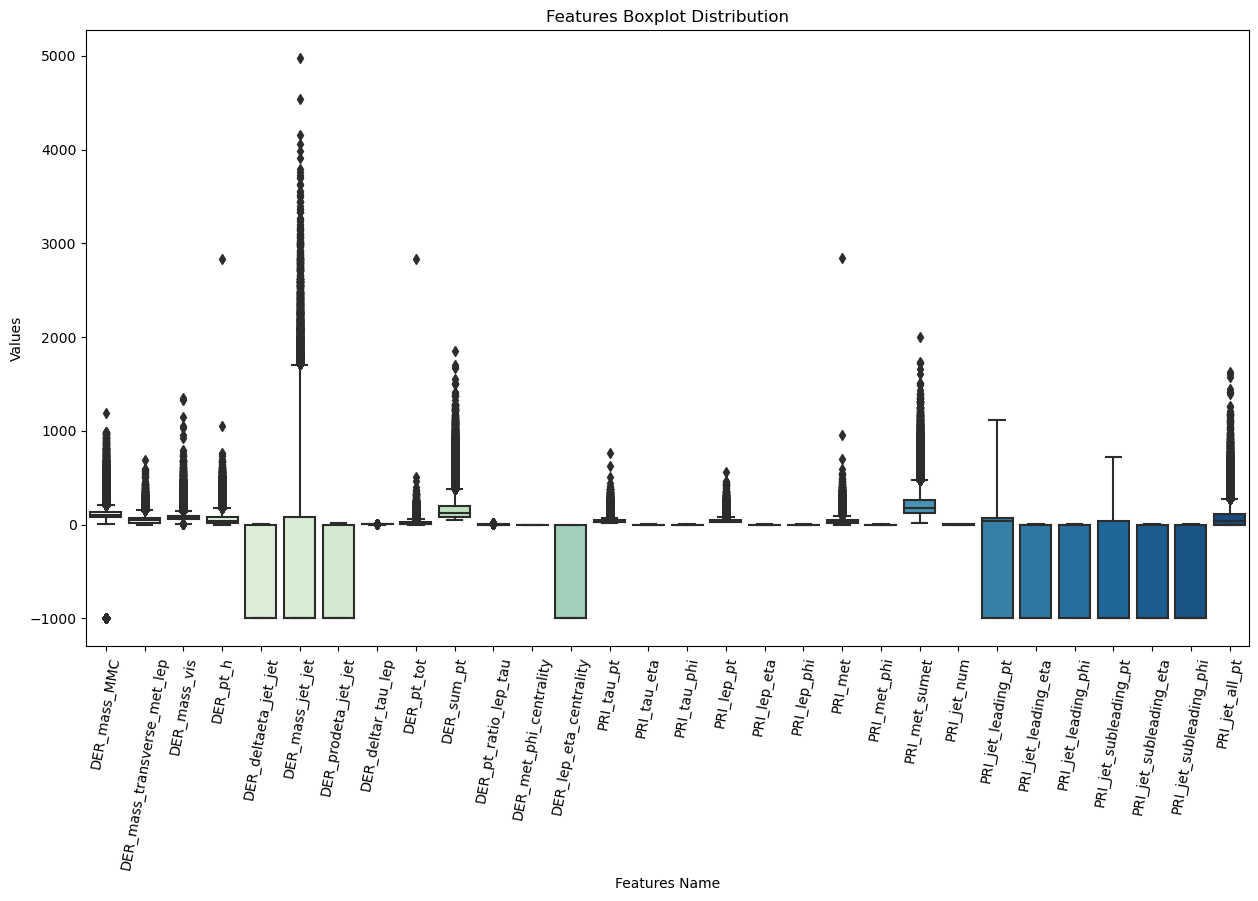

In [8]:
palette = sns.color_palette("GnBu", n_colors=30)


figure = plt.figure(figsize=(15,8))
ax = sns.boxplot(data = tX, palette = palette)
ax.set_xticklabels(features_name, rotation = 80)
plt.title("Features Boxplot Distribution")
plt.xlabel('Features Name')
plt.ylabel('Values')
plt.show()

*need to standarize the features + remove outliers*

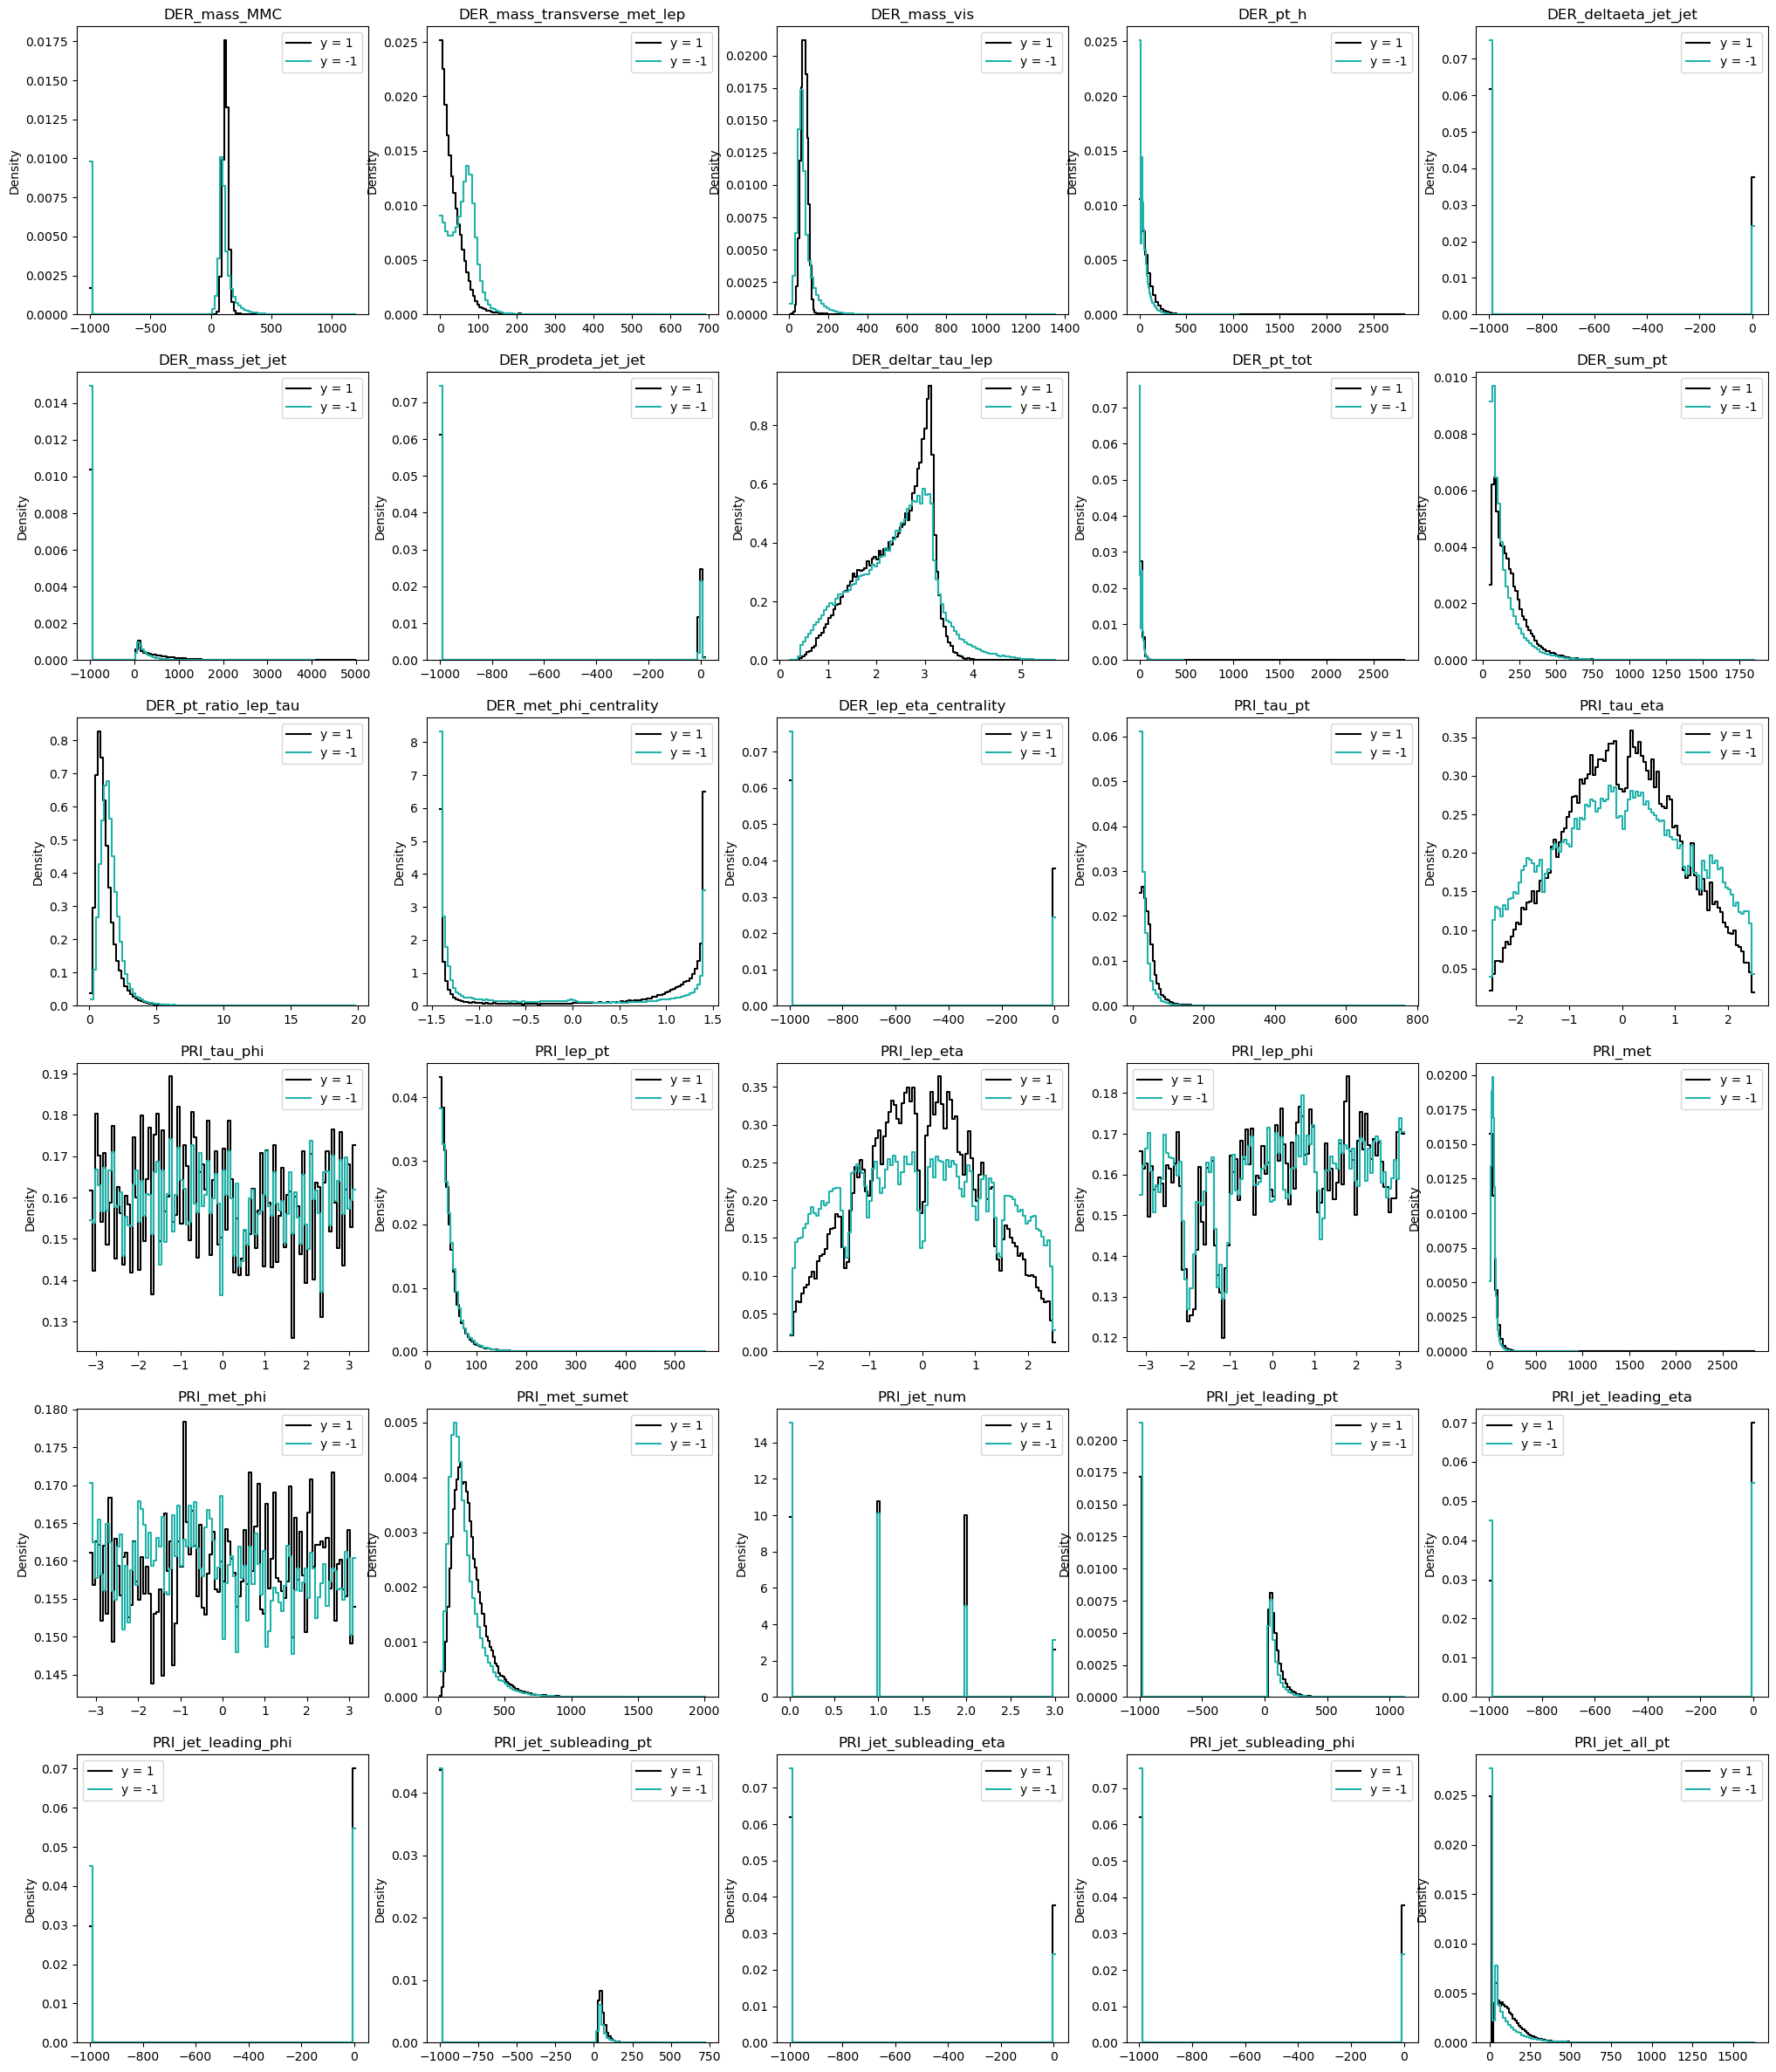

In [9]:
fig= plt.figure(figsize=(25,30))

for idx in range(tX.shape[1]): 
    ax=plt.subplot(6,5,idx+1)
    
    #density plot of each feature depending on the y response
    sns.histplot(data=tX[y==1, idx], ax=ax, element="step", 
                 fill=False, color = 'black', stat = 'density', bins = 100)
    sns.histplot(data=tX[y==-1, idx], ax=ax, element="step",
                 fill=False, color = 'lightseagreen', stat = 'density', bins = 100)
    
    #plot parameters
    ax.set_title(features_name[idx])
    ax.legend(["y = 1", "y = -1"])

*NB : test without PRI_tau_phi, PRI_met_phi, PRI_lep_phi*

# Data Preprocessing

In [ ]:
preprocessed_X, preprocessed_y = preprocess_data(tX, y, False)
preprocessed_X_test, y_test = preprocess_data(tX_test, y_test, True)

In [43]:
preprocessed_X

array([[  1.   , 138.47 ,  51.655, ...,  -0.277, 258.733, 113.497],
       [  1.   , 160.937,  68.768, ...,  -1.916, 164.546,  46.226],
       [  1.   , 112.406, 162.172, ...,  -2.186, 260.414,  44.251],
       ...,
       [  1.   , 105.457,  60.526, ...,  -2.89 , 198.907,  41.992],
       [  1.   ,  94.951,  19.362, ...,   0.811, 112.718,   0.   ],
       [  1.   , 112.406,  72.756, ...,  -1.596,  99.405,   0.   ]])

In [45]:
preprocessed_X[:,1:].shape

(245504, 20)

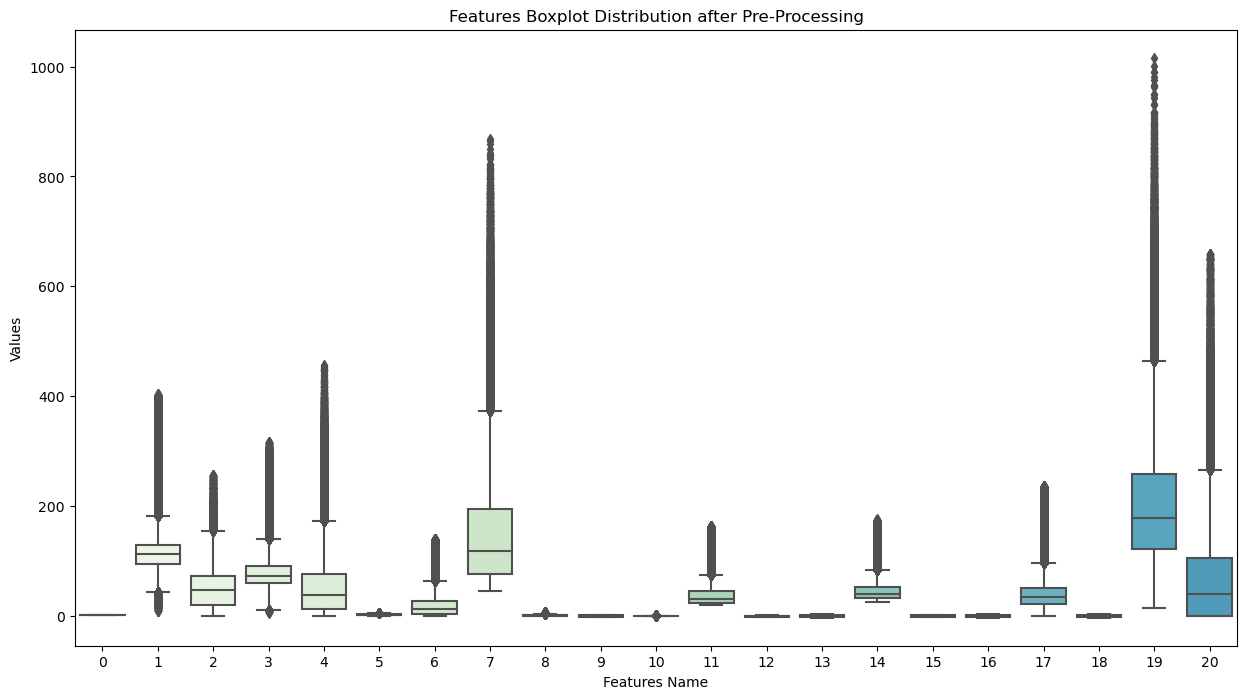

In [13]:
palette = sns.color_palette("GnBu", n_colors=30)
figure = plt.figure(figsize=(15,8))
ax = sns.boxplot(data = preprocessed_X, palette = palette)
#ax.set_xticklabels(features_name, rotation = 80)
plt.title("Features Boxplot Distribution after Pre-Processing")
plt.xlabel('Features Name')
plt.ylabel('Values')
plt.show()

# Method implementation

In [14]:
seed = 2
k_fold = 5

## Least square with GD

### Parameters in order to tune
- gamma (learning rate)
- D (degree of polynomial thingy)

*parameters : learning rate, number of iteration, fold, degree
--> tune learning rate & degree ?*

In [27]:
method = least_squares_GD
degree=np.arange(1,10)
gamma = 0.1
max_iters = 50
parameters = []
for d in degree:
    parameters.append({'gamma':gamma, 'degree':d, 'max_iters':max_iters})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters[idx_best])

Tested parameters
 [{'gamma': 0.1, 'degree': 1, 'max_iters': 50}, {'gamma': 0.1, 'degree': 2, 'max_iters': 50}, {'gamma': 0.1, 'degree': 3, 'max_iters': 50}, {'gamma': 0.1, 'degree': 4, 'max_iters': 50}, {'gamma': 0.1, 'degree': 5, 'max_iters': 50}, {'gamma': 0.1, 'degree': 6, 'max_iters': 50}, {'gamma': 0.1, 'degree': 7, 'max_iters': 50}, {'gamma': 0.1, 'degree': 8, 'max_iters': 50}, {'gamma': 0.1, 'degree': 9, 'max_iters': 50}]
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 standard deviation
There's 0 stand

KeyboardInterrupt: 

Tested parameters
 [{'gamma': 1e-07, 'degree': 1, 'max_iters': 50}, {'gamma': 1e-06, 'degree': 1, 'max_iters': 50}, {'gamma': 1e-05, 'degree': 1, 'max_iters': 50}, {'gamma': 0.0001, 'degree': 1, 'max_iters': 50}, {'gamma': 0.001, 'degree': 1, 'max_iters': 50}, {'gamma': 0.01, 'degree': 1, 'max_iters': 50}, {'gamma': 0.1, 'degree': 1, 'max_iters': 50}, {'gamma': 1.0, 'degree': 1, 'max_iters': 50}]
Best parameters
 {'gamma': 1e-07, 'degree': 1, 'max_iters': 50}


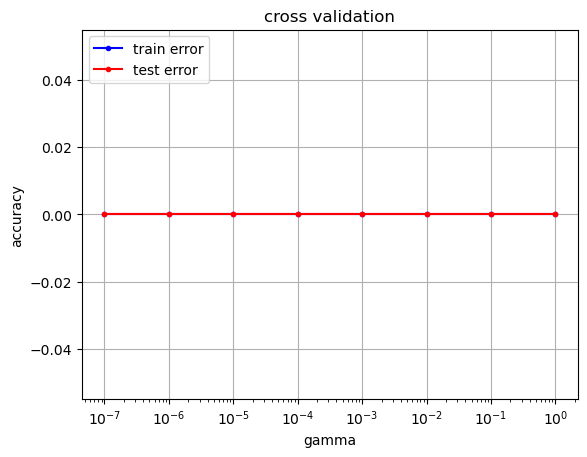

In [18]:
method = least_squares_GD
degree = parameters[idx_best]['degree']
gammas= np.logspace(-7, 0, 8)
max_iters = 50
parameters = []
for g in gammas:
    parameters.append({'gamma':g, 'degree':degree, 'max_iters':max_iters})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(gammas, acc_tr_deg, acc_te_deg, 'gamma')
print('Best parameters\n', parameters[idx_best])

## Least square with SGD

### Parameters for this method
- degree
- gamma (lr)
- max_iters

In [22]:
method = least_squares_SGD
degree=np.arange(1,10)
gamma = 0.1
max_iters = 50
parameters = []
for d in degree:
    parameters.append({'gamma':gamma, 'degree':d, 'max_iters':max_iters})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters[idx_best])

Tested parameters
 [{'gamma': 0.1, 'degree': 1, 'max_iters': 50}, {'gamma': 0.1, 'degree': 2, 'max_iters': 50}, {'gamma': 0.1, 'degree': 3, 'max_iters': 50}, {'gamma': 0.1, 'degree': 4, 'max_iters': 50}, {'gamma': 0.1, 'degree': 5, 'max_iters': 50}, {'gamma': 0.1, 'degree': 6, 'max_iters': 50}, {'gamma': 0.1, 'degree': 7, 'max_iters': 50}, {'gamma': 0.1, 'degree': 8, 'max_iters': 50}, {'gamma': 0.1, 'degree': 9, 'max_iters': 50}]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/ML/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0b/6_94_7yn6v76d3hglljc2zq40000gn/T/ipykernel_3538/1062037326.py", line 9, in <cell line: 9>
    acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
  File "/Users/alicia/Documents/GitHub/ML/project/cross_val.py", line 79, in cross_tunning
    acc_tr_, acc_te_ = cross_validation(y, x, k_indices, k_fold, method, **params)
  File "/Users/alicia/Documents/GitHub/ML/project/cross_val.py", line 58, in cross_validation
    w, loss = method(y_tr, tx_tr, **params_without_degree)
  File "/Users/alicia/Documents/GitHub/ML/project/implementations.py", line 121, in least_squares_SGD
    for y_batch, tx_batch in batch_iter(y, tx, batch_size=1, num_batches=1):
  File "/Users/alicia/Documents/GitHub/ML/project/implementations.py", line 204, in batch

In [ ]:
method = least_squares_SGD
degree = parameters[idx_best]['degree']
gammas= np.logspace(-7, 0, 8)
max_iters = 50
parameters = []
for g in gammas:
    parameters.append({'gamma':g, 'degree':degree, 'max_iters':max_iters})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(gammas, acc_tr_deg, acc_te_deg, 'gamma')
print('Best parameters\n', parameters[idx_best])

## Least square 

### Parameters to tune for this method
- degree
  

Not done yet. Singular matrix error. Flemme.

Tested parameters
 [{'degree': 1}, {'degree': 2}, {'degree': 3}, {'degree': 4}, {'degree': 5}, {'degree': 6}, {'degree': 7}, {'degree': 8}, {'degree': 9}]


ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

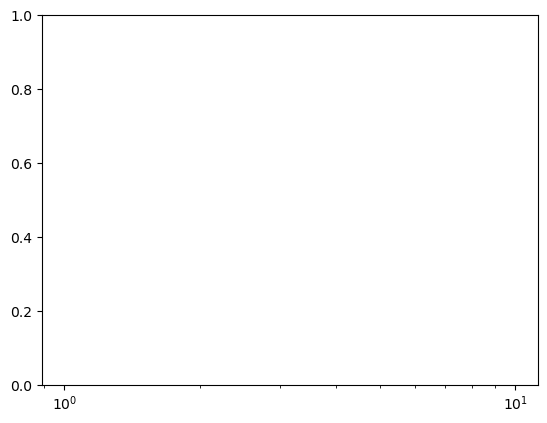

In [ ]:
method = least_squares
degree = np.arange(1,10)
max_iters = 50
parameters = []
for d in degree:
    parameters.append({'degree':d})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(gammas, acc_tr_deg, acc_te_deg, 'gamma')
print('Best parameters\n', parameters[idx_best])

## Ride Regression 

### Parameters for this method
- degree
- lambda_

In [ ]:
method = ridge_regression
degree=np.arange(1,10)
lambda_ = 0.1
parameters = []
for d in degree:
    parameters.append({'lambda_':lambda_, 'degree':d})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters[idx_best])

In [ ]:
method = ridge_regression
degree = parameters[idx_best]['degree']
lambdas_ = np.logspace(-7, 0, 8)
parameters = []
for l in lambdas_:
    parameters.append({'lambda_':l, 'degree':degree})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(gammas, acc_tr_deg, acc_te_deg, 'gamma')
print('Best parameters\n', parameters[idx_best])

## Logistic

### Parameters for this method
- initinal_w (set to 0 for simplicity)
- max_iters
- gamma
- degree

In [ ]:
method = logistic_regression
degree = np.arange(1,10)
gamma = 0.01 # note lower gamma here. Otherwise no convergence.
max_iters = 50
parameters = []
for d in degree:
    parameters.append({'gamma':gamma, 'degree':d, 'max_iters':max_iters, 'initial_w':None})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(degree, acc_tr_deg, acc_te_deg, 'degree')
print('Best parameters\n', parameters[idx_best])

In [ ]:
method = logistic_regression
degree = 1
gammas= np.logspace(-7, 0, 8)
max_iters = 50
parameters = []
for g in gammas:
    parameters.append({'gamma':g, 'degree':degree, 'max_iters':max_iters, 'initial_w':None})
print('Tested parameters\n', parameters)
acc_tr_deg, acc_te_deg, idx_best = cross_tunning(preprocessed_y, preprocessed_X,
                                         k_fold=k_fold, method=method , parameters=parameters, seed=seed)


cross_validation_visualization(gammas, acc_tr_deg, acc_te_deg, 'gamma')
print('Best parameters\n', parameters[idx_best])

## Regularized logistic